In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, ll_to_xy,latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim, vertcross,CoordPair
import pandas as pd
from netCDF4 import Dataset
import netCDF4
import h5py as h5
import csv
from scipy import stats
import matplotlib as mpl
import glob
import pyproj
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import seaborn as sns
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
import xarray as xr
from metpy.io import Level2File
from functions_calc import geo_idx
import math

In [2]:
#We will need to find the position of the king air relative to the radar position. This block is up top
#because this file does not change

#First open file then 
f = Dataset("20170108c1.nc")
ptime = f.variables['TIME'][:]
plons = f.variables['glon'][:]
plats = f.variables['glat'][:]

In [412]:
file_name = 'cfrad.20170108_045528.418_to_20170108_045538.895_DOW7_v309_s10_el8.00_SUR.nc'
start_time = file_name[16:21]
start_time = file_name[16]+":"+file_name[17:19]+":"+file_name[19:21]
end_time = file_name[39:44]
end_time = file_name[39]+":"+file_name[40:42]+":"+file_name[42:44]
elevation_angle = file_name[-12:-7]
if elevation_angle[0] == "l":
    elevation_angle = file_name[-11:-7]
el = str(elevation_angle)
el.replace(".","_")
picname = "PPI_"+str(start_time)+"_"+str(end_time)+"_"+el+".png"
print(picname)

PPI_4:55:28_4:55:38_8.00.png


In [413]:
tenkm_height = str(math.tan(math.radians(float(elevation_angle)))*10+2.138)[0:5]
twentykm_height = str(math.tan(math.radians(float(elevation_angle)))*20+2.138)[0:5]
thirtykm_height = str(math.tan(math.radians(float(elevation_angle)))*30+2.138)[0:5]
fortykm_height = str(math.tan(math.radians(float(elevation_angle)))*40+2.138)[0:5]
fiftykm_height = str(math.tan(math.radians(float(elevation_angle)))*50+2.138)[0:5]

In [414]:
print(tenkm_height)

3.543


In [415]:
print(ptime[start_index[0]])
print(plats[start_index[0]])
print(plons[start_index[0]])
print(Radar_lat[0])
print(Radar_lon[0])

[45517.]
[44.207787]
[-115.86693]
44.207637786865234
-116.06920623779297


In [416]:
#We want to plot the planes position on the PPI


#Start by getting the start time from the file
ind = str(start_time)
ind = ind[0]+ind[2:4] + ind[-2]+ind[-1]+".0"

#Find where that start time is in the plane index
start_index = np.where(ptime == float(ind))

#Same here but for the end
ind = str(end_time)
ind = ind[0]+ind[2:4] + ind[-2]+ind[-1]+".0"
end_index = np.where(ptime == float(ind))


#One latitude line = 111KM
#One longitude line = 80KM

#Make sure they're correct
print(start_time)
print(end_time)
print(ptime[start_index[0]])
print(ptime[end_index[0]])


#Now let's get the planes position. I know this is inefficient but I was having trouble just using the start and end index from above
#Define the X and Y of plane we'll use to plot
Yplane = []
Xplane = []

#Define this u counter variable
u = int(start_index[0])

#Count through start to end of PPI scan
while u <= end_index[0]:
    
    #Each latitude is 111 km in distance. 44.2 is the lat of the radar
    Yplane.append((plats[u]-44.20763779)*111)
    
    #Each longitude is 80km. 116 is the longitude of the radar.
    #We're converting these into Km because that's how the plotting is
    #X,Y in KM relative to radar position
    Xplane.append((abs(plons[u])-abs(-116.06920624))*80)
    u = u + 1

Xplane = np.array(Xplane) *-1
print(Xplane)
print(Yplane)

4:55:28
4:55:38
[45528.]
[45538.]
[15.34851092 15.27282732 15.19714373 15.12146014 15.04577654 14.97009295
 14.89440936 14.81872576 14.74304217 14.66735857 14.59228533]
[0.03472102655276643, 0.03641475213870393, 0.03768504632815706, 0.03895534051761018, 0.04022563470706331, 0.04149592889651643, 0.04234279168948518, 0.04361308587893831, 0.04445994867190706, 0.04573024286136018, 0.04657710565432893]


In [417]:
#Open the PPI File
ncfile = Dataset(file_name)

#Variables in Time (1801) and Range (1000)

#Get the variables

#Latitude and Longtidue of Radar position. Constant to the radar's position
#Index = Time
Radar_lat = np.array(ncfile['latitude'])
Radar_lon = np.array(ncfile['longitude'])

#Distance from Radar to the Center of gate (m)
#Index = Range
Range = np.array(ncfile['range'])

#Azimuth angle from True North. Assume starting rotation to West (Degrees)
#Index = Time
Azimuth = np.array(ncfile['azimuth'])

#Elevation angle of Radar. This should be mostly the same except when it's transitioning (Degrees)
#Index = Time
Elevation = np.array(ncfile['elevation'][:])

#Equivalent reflectivity factor, horizontal channel, offset-corrected (dBZ)
#Index = Time, Range
dBZ = np.array(ncfile['DBZHCC'])

#Quality Flag, determines if it's cluttered (0), precipitation (1), or clean air (2)
#Index = Time, Range
QF = np.array(ncfile['QFLAG'])

#Antenna Transition, indicates when antenna is transitioning to a new elevation angle. (1) if in transition (0) if otherwise
#Index = Time
Transition = np.array(ncfile['antenna_transition'])
height_agl = np.array(ncfile['altitude'])


In [418]:
#We want to find the straight line Distance of the returned power to the radar.
#To do this we will use the Range (H), Elevation Angle (Theta), and Trig
#to determine the straight line distance (D) of the returned power.

#Create a new variable called distance with shape (time, range)
distance = np.empty((dBZ.shape[0],1000))
distance[:] = np.nan

#We will loop through each range, over each Azimuth. So starting with the 0th Range, and 0th Azimuth
R = 0
D = 0

#Loop through each Range
while R < len(Range):
    #Starting at 0 Azimuth for reach range
    D = 0
    
    #Our range is our hypotenuse
    Hypot = Range[R]
    
    #Loop through each azimuth
    while D < len(Azimuth):
        
        #Get the distance using cos(Theta)*Hypotenuse.
        #we also need to convert Elevation degrees into radians for math.cos to work
        distance[D,R] = Hypot*math.cos(math.radians(Elevation[D]))
        D = D + 1
    R = R + 1
    
    #Checking to see how far the loop is
    if R == 100:
        print(R)
    if R == 500:
        print(R)
    

100
500


In [419]:
#Now we need to find the position of the return on a 2D surface relative to the radar
#To do this, we will utilze the Straight Line Distance, and the Azimuth angle
#The azimuth angle is degrees from true north.

#At this point, we need to define our coordinate system. Our goal is to convert this into an X,Y
#Cartesian Coordniate system. We will define our X range as [-50,50] km west and east of the Radar.
#We will define our Y range as [-50,50] km North and East of the radar.

#Define the X variables

X = np.empty((dBZ.shape[0],1000))
X[:] = np.nan

#Define the Y variables

Y = np.empty((dBZ.shape[0],1000))
Y[:] = np.nan

#First position in Time
Time = 0

for Phi in Azimuth:
    #Going to add 90 degrees to Phi because it is degrees from true north. This way
    #We get the angle from the positive X axis. It makes it 'easier' to know what positive
    #and negative value you'll get from sin and cos
    
    Phi = Phi + 90
    
    X[Time,:] = math.cos(math.radians(Phi))*distance[Time,:]
    Y[Time,:] = math.sin(math.radians(Phi))*distance[Time,:]
    
    
    Time = Time + 1
#Make the X and Y axis in KM        
X = X / 1000
Y = Y / 1000
X = X * -1

In [420]:
#Quality control

#We want to find where the QF isn't equal 1, or when there isn't precip.
index = np.where((QF[:,:] != 1))


#Set those regions to nan
dBZ[index[0],index[1]] = np.nan


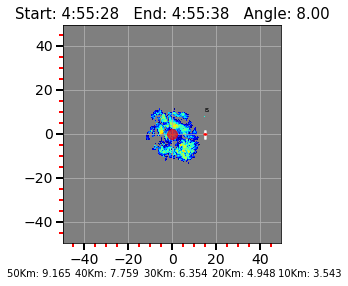

In [421]:
fig, ax = plt.subplots()
plt.plot(0, 0, marker='o', \
         color='red', markersize=10, \
        alpha=0.7)

plt.plot(Xplane, Yplane, marker='|', \
         color='white', markersize=9, \
        alpha=0.4)
plt.plot(Xplane, Yplane, marker='o', \
         color='red', markersize=1, \
        alpha=0.4)

plt.text(Xplane[0],Yplane[0]+10, "S", fontsize = 5, color = "black")
plt.text(Xplane[-1],Yplane[-1]+10, "E", fontsize = 5, color = "black")
levs = np.arange(1,30,1)
ax.contourf(X, Y, dBZ,levs, cmap = "jet")
ax.set_facecolor('tab:gray')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
ax.set_aspect('equal')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.title("Start: "+start_time +"   " + "End: " + end_time + "   " + "Angle: " +elevation_angle, fontsize = 15)
plt.text(-75,-65, "50Km: "+fiftykm_height, fontsize = 10, color = "black")
plt.text(-44,-65, "40Km: "+fortykm_height, fontsize = 10, color = "black")
plt.text(-13,-65, "30Km: "+thirtykm_height, fontsize = 10, color = "black")
plt.text(18,-65, "20Km: "+twentykm_height, fontsize = 10, color = "black")
plt.text(48,-65, "10Km: "+tenkm_height, fontsize = 10, color = "black")
plt.savefig(picname, dpi = 400)